In [ ]:
!git init
!git config --global user.email nadaaker1999@gmail.com
!git config --global user.name alakerna

In [ ]:
!git clone 

In [ ]:
!git add -A

In [ ]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader, Dataset, ConcatDataset

from PIL import Image

from matplotlib import pyplot as plt

from google.colab import drive
from os import listdir
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
class ImagePairDataset(Dataset):
    def __init__(self, rgb_path, depth_path, transform=None):
        self.rgb_paths = [rgb_path + f for f in listdir(rgb_path)]
        self.depth_paths = [depth_path + f for f in listdir(depth_path)]

        size = min(len(self.rgb_paths), len(self.depth_paths))

        self.rgb_paths = self.rgb_paths[:size-2]
        self.depth_paths = self.depth_paths[:size-2]

        self.transform = transform
        
    def __getitem__(self, index):

        #rgb = np.moveaxis(np.array(Image.open(self.rgb_paths[index])), 0, -1)
        rgb = np.array(Image.open(self.rgb_paths[index]))
        depth = np.array(Image.open(self.depth_paths[index])) / 65536

        try:
            while rgb.shape[2] != 3:
                index -= 1
                rgb = np.array(Image.open(self.rgb_paths[index]))
                depth = np.array(Image.open(self.depth_paths[index])) / 65536
        except:
            index -= 1
            rgb = np.array(Image.open(self.rgb_paths[index]))
            depth = np.array(Image.open(self.depth_paths[index])) / 65536

        if self.transform:
            rgb = self.transform(rgb)
            depth = self.transform(depth).squeeze()
            
        return rgb, depth
    
    def __len__(self):
        return min(len(self.rgb_paths), len(self.depth_paths))

class Baseline1(nn.Module):
    def __init__(self):
        super(Baseline1, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 20, kernel_size=11, padding=5),
            nn.Conv2d(20, 40, kernel_size=11, padding=5),
            nn.Conv2d(40, 20, kernel_size=7, padding=3),
            nn.Conv2d(20, 1, kernel_size=7, padding=3)
        )

    def forward(self, x):
        return self.conv(x)

def save_tensor(path, tensor, name):
    pickle.dump(
        tensor,
        open(path+name+".t", "wb")
    )

def load_tensor(path, name):
    return pickle.load(open(path+name+".t", "rb"))

def load_dataset(root_path, batch_size=16, ratios=(.7,.15,.15)):
    sub_datasets = []
    for scene in listdir(root_path):
        sub_datasets.append(
            ImagePairDataset(
                rgb_path = root_path + scene + "/rgb/",
                depth_path = root_path + scene + "/depth/",
                transform = transforms.ToTensor()
            )
        )

    dataset = ConcatDataset(sub_datasets)
    num_samples = len(dataset)
    len1 = int(num_samples*ratios[0])
    len2 = int(num_samples*ratios[1])
    train_data, val_data, test_data = random_split(dataset,
                                    (len1, len2, num_samples-len1-len2))
    
    print(len(train_data), len(val_data), len(test_data))
    
    train_loader = DataLoader(train_data, batch_size=batch_size, 
                              shuffle=False, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=batch_size, 
                              shuffle=False, num_workers=0)
    test_loader = DataLoader(test_data, batch_size=batch_size, 
                              shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

def validation_loss(model, criterion, val_loader, batch_size):

    total_loss = 0.0

    for i, (rgb, depth) in enumerate(val_loader):

        print("\rValidation Batches: {}/{}".format(i+1, \
                    int(len(val_loader.dataset)/batch_size)+1), end="")

        if torch.cuda.is_available():
            rgb = rgb.cuda()
            depth = depth.cuda()
        
        pred = model(rgb)

        loss = torch.sqrt(criterion(depth, pred.squeeze()))
        #del pred
        total_loss += loss.item()
        #del loss
    
    return total_loss / len(val_loader.dataset)

def batch_loss(model, criterion, val_loader):
    for i, (rgb, depth) in enumerate(val_loader):

        if torch.cuda.is_available():
            rgb = rgb.cuda()
            depth = depth.cuda()
        
        pred = model(rgb)

        loss = torch.sqrt(criterion(depth, pred.squeeze()))
        return loss.item()

def train(model, batch_size=16, learning_rate=0.01, num_epochs=10):

    torch.autograd.set_detect_anomaly(True)

    plotlosses = PlotLosses()

    train_loader, val_loader = load_dataset(nada_path, batch_size=batch_size)[:2]

    torch.manual_seed(1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, \
                                        factor=0.5, patience=10, verbose=True)

    for epoch in range(num_epochs):

        total_loss = 0.0

        for i, (rgb, depth) in enumerate(train_loader):

            if torch.cuda.is_available():
                rgb = rgb.cuda()
                depth = depth.cuda()
            
            optimizer.zero_grad()

            pred = model(rgb)

            loss = torch.sqrt(criterion(depth, pred.squeeze()))
            #del pred

            val_loss = batch_loss(model, criterion, val_loader)

            if i % 5 == 0:
                plotlosses.update({
                    'loss': loss.item(),
                    'val_loss': val_loss
                })
                plotlosses.send()

            scheduler.step(val_loss)
            
            print("\rTraining Batches: {}/{}\tLoss: {}".format(i+1, \
                        int(len(train_loader.dataset)/batch_size)+1, \
                        loss.item()), end="")
            
            total_loss += loss.item()
            #del loss
            loss.backward()
            optimizer.step()
        '''
        plotlosses.update({
            'loss': loss.item() / len(train_loader.dataset),
            'val_loss': validation_loss(model, criterion, val_loader, batch_size)
        })
        plotlosses.send()
        '''


In [ ]:
class Baseline1(nn.Module):
    def __init__(self):
        super(Baseline1, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=11, padding=5),
            nn.Conv2d(30, 50, kernel_size=11, padding=5),

            nn.Conv2d(50, 50, kernel_size=7, padding=3),


            nn.Conv2d(30, 5, kernel_size=7, padding=3),
            nn.Conv2d(5, 1, kernel_size=5, padding=2),
        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
nada_path = "/content/gdrive/My Drive/Industrial Engineering/Second Year/APS360/APS360_Project/Data/"
train_loader, val_loader, test_loader = load_dataset(nada_path)

3669 786 787


torch.Size([16, 3, 480, 640]) torch.Size([16, 480, 640])


TypeError: ignored

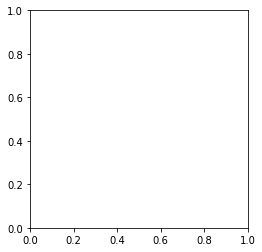

In [ ]:
for i, batch in enumerate(train_loader):
    rgb, depth = batch

    print(rgb.shape, depth.shape)

    plt.imshow(rgb[0])
    plt.show()
    plt.imshow(depth[0])
    plt.show()
    break

In [ ]:
torch.cuda.empty_cache()

baseline1 = Baseline1()

if torch.cuda.is_available():
    print("GPU available")
    baseline1.cuda()

train(baseline1, batch_size=64, learning_rate=0.0001, num_epochs=2)